In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_root)

In [ ]:
import pandas as pd
import numpy as np
import mpslib as mps
import matplotlib.pyplot as plt

from scripts.utils import plot_realizations_enhanced, npy_to_hard_data, plot_two_point_correlation_comparison, plot_mse_comparison
from scipy.ndimage import zoom
from sklearn.metrics import mean_squared_error

# Setup MPSLib

In [3]:
simulation_grid_size = [1000, 1000, 1]    # Output shape
number_of_realizations = 9

template_size = [8, 7, 1]
n_multiple_templates = 3

In [4]:
# Initialize MPSlib using the mps_snesim_tree algorithm with specified simulation grid
O = mps.mpslib(method='mps_snesim_tree', simulation_grid_size=simulation_grid_size)

# Core simulation parameters
O.par['debug_level'] = -1  # Controls verbosity: -1=silent, 0=minimal, 1+=verbose
O.par['n_cond'] = 12  # Number of conditional data points used for pattern matching
O.par['n_real'] = number_of_realizations  # Number of realizations to generate
O.par['n_threads'] = 10  # Number of parallel threads for computation
O.par['do_entropy'] = 1  # Calculate entropy maps: 0=no, 1=yes
O.par['n_min_node_count'] = 2  # Minimum node count for pattern acceptance

# Grid and template configuration
O.par['simulation_grid_size'] = np.array(simulation_grid_size)  # Output grid dimensions [nx, ny, nz]
O.par['template_size'] = np.array(template_size)  # Search template dimensions [nx, ny, nz]
O.par['n_multiple_grids'] = n_multiple_templates  # Number of multigrid levels for computational efficiency

# Additional default parameters (automatically set by mpslib):
# rseed: Random seed for reproducibility
# n_max_cpdf_count: Maximum conditional probability density function count
# out_folder: Output directory for results
# ti_fnam: Training image filename
# origin: Grid origin coordinates
# grid_cell_size: Cell size in each dimension
# mask_fnam: Mask file for simulation domain
# hard_data_fnam: Hard conditioning data file
# shuffle_simulation_grid: Simulation path strategy (0=sequential, 1=random, 2=preferential)
# entropyfactor_simulation_grid: Entropy factor for preferential path
# shuffle_ti_grid: Training image scanning strategy
# hard_data_search_radius: Search radius for hard data conditioning
# soft_data_categories: Categories for soft data conditioning
# soft_data_fnam: Soft conditioning data file
# do_estimation: Perform estimation instead of simulation
# n_min_node_count: Minimum node count for pattern acceptance

Using mps_snesim_tree installed in /home/pedro2/.local/lib/python3.10/site-packages/mpslib/bin (scikit-mps in /home/pedro2/.local/lib/python3.10/site-packages/mpslib/mpslib.py)


# Choose training image

In [5]:
# Select training image parameters
idx = 1  # Choose Parker binary training image #4
downsample_factor = 1  # Use full resolution (no downsampling)

# Construct file paths for the training image data
training_path = f"../../data/eas/downsample_factor_{downsample_factor}/Parker_binary_{idx}"

# Load training image in EAS format (for MPSlib compatibility)
training_path_eas = training_path + ".dat"
training_data_eas = mps.eas.read(filename=training_path_eas)

# Load training image as numpy arrays for visualization and analysis
training_data_array = np.load(training_path + ".npy")  # Original binary data
training_data_transformed_array = np.load(training_path + "_transformed.npy")  # Processed/transformed version

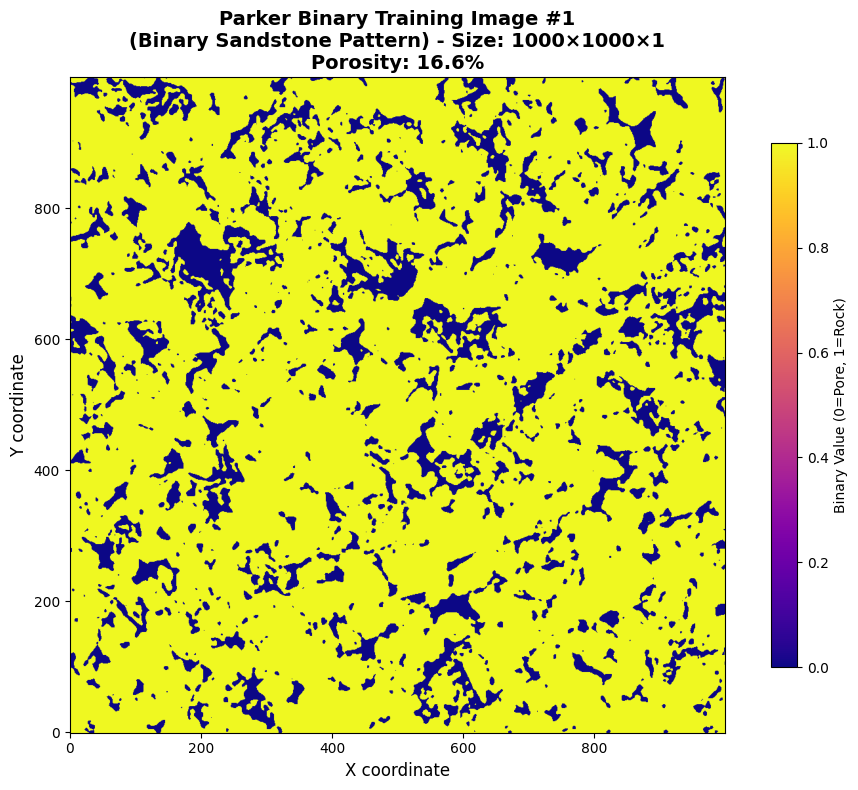

In [6]:
# Calculate porosity (percentage of pore space, where 0=Pore, 1=Rock)
porosity = np.mean(training_data_array[:,:,0] == 0) * 100

# Create a larger, better formatted plot
plt.figure(figsize=(10, 8))
plt.imshow(training_data_array[:,:,0].T, cmap='plasma', origin='lower')
plt.title(f'Parker Binary Training Image #{idx}\n(Binary Sandstone Pattern) - Size: {training_data_array.shape[0]}×{training_data_array.shape[1]}×{training_data_array.shape[2]}\nPorosity: {porosity:.1f}%', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.colorbar(label='Binary Value (0=Pore, 1=Rock)', shrink=0.8)
plt.tight_layout()
plt.show()


# Choose hard data image

In [7]:
# Select hard data parameters
idx = 2  # Choose Parker binary hard data image #4
downsample_factor = 10  # Use downsampled version (lower resolution for conditioning)

# Construct file path for the hard data
hard_path = f"../../data/eas/downsample_factor_{downsample_factor}/Parker_binary_{idx}"

# Load hard data in EAS format (for MPSlib compatibility)
hard_path_eas = hard_path + ".dat"
hard_data_eas = mps.eas.read(filename=hard_path_eas)

# Load processed hard data arrays
hard_data_transformed_array = np.load(hard_path + "_transformed.npy")  # Transformed version for visualization
hard_data = npy_to_hard_data(hard_path + "_transformed.npy", downsample_factor=downsample_factor)  # Convert numpy array to MPSlib hard data format

✅ Converted ../../data/eas/downsample_factor_10/Parker_binary_2_transformed.npy to hard data format
   Array shape: (99, 99, 100)
   Hard data points: 9801
   Value range: [0.00, 1.00]
   Coordinate scaling factor: 10
   Scaled coordinate range: X[0, 980.0], Y[0, 980.0], Z[0, 0.0]


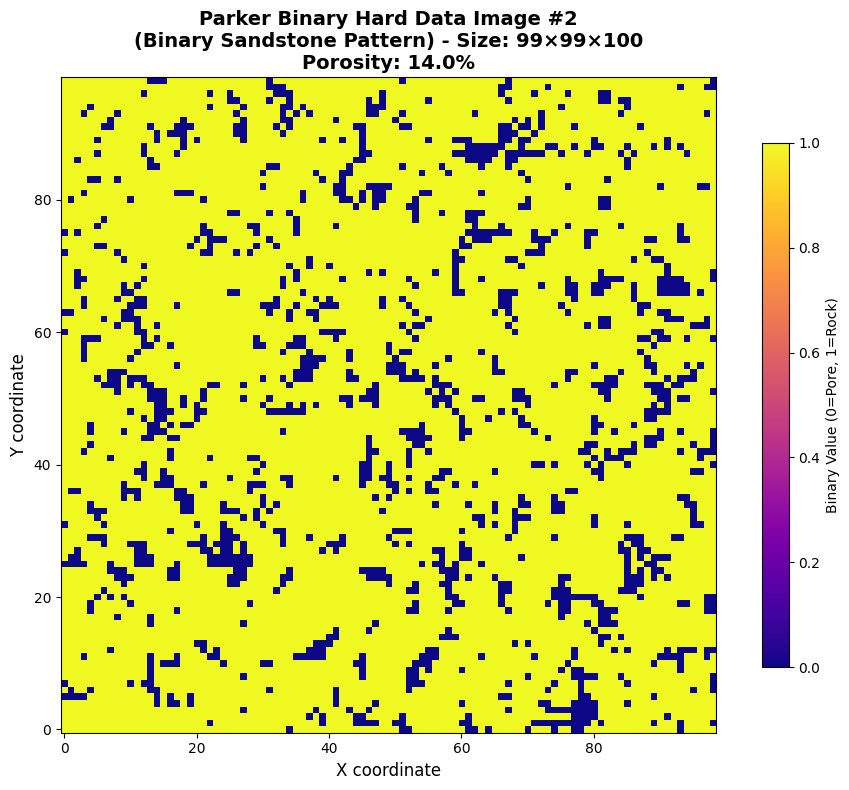

In [8]:
# Calculate porosity (percentage of pore space, where 0=Pore, 1=Rock)
porosity = np.mean(hard_data_transformed_array[:,:,0] == 0) * 100

# Create a larger, better formatted plot
plt.figure(figsize=(10, 8))
plt.imshow(hard_data_transformed_array[:,:,0].T, cmap='plasma', origin='lower')
plt.title(f'Parker Binary Hard Data Image #{idx}\n(Binary Sandstone Pattern) - Size: {hard_data_transformed_array.shape[0]}×{hard_data_transformed_array.shape[1]}×{hard_data_transformed_array.shape[2]}\nPorosity: {porosity:.1f}%', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.colorbar(label='Binary Value (0=Pore, 1=Rock)', shrink=0.8)
plt.tight_layout()
plt.show()


# Simulation and parameters

In [9]:
O.par['ti_fnam'] = training_path + ".dat"
O.par["hard_data_fnam"] = hard_path_eas
O.d_hard = hard_data

In [11]:
O.par

{'n_real': 9,
 'rseed': 1,
 'n_max_cpdf_count': 1,
 'out_folder': '.',
 'ti_fnam': '../../data/eas/downsample_factor_1/Parker_binary_1.dat',
 'simulation_grid_size': array([1000, 1000,    1]),
 'origin': array([0., 0., 0.]),
 'grid_cell_size': array([1, 1, 1]),
 'mask_fnam': 'mask.dat',
 'hard_data_fnam': '../../data/eas/downsample_factor_10/Parker_binary_2.dat',
 'shuffle_simulation_grid': 2,
 'entropyfactor_simulation_grid': 4,
 'shuffle_ti_grid': 1,
 'hard_data_search_radius': 1,
 'soft_data_categories': array([0, 1]),
 'soft_data_fnam': 'soft.dat',
 'n_threads': 10,
 'debug_level': -1,
 'do_estimation': 0,
 'do_entropy': 1,
 'template_size': array([8, 7, 1]),
 'n_multiple_grids': 3,
 'n_min_node_count': 2,
 'n_cond': 12}

In [12]:
O.run_parallel()

parallel: Using 9 of max 10 threads


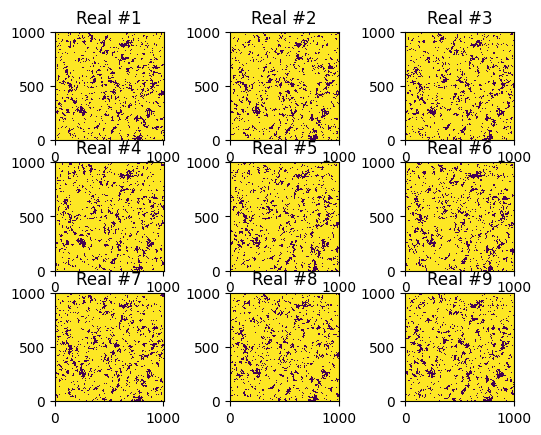

In [13]:
O.plot_reals()

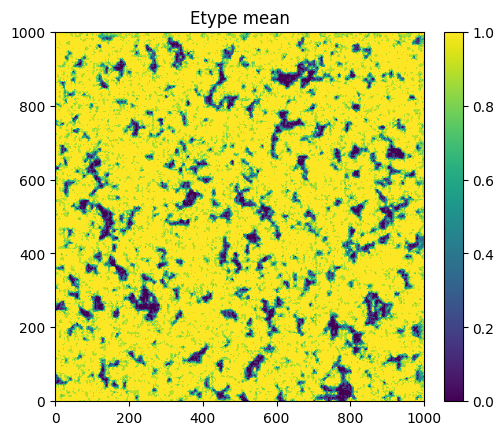

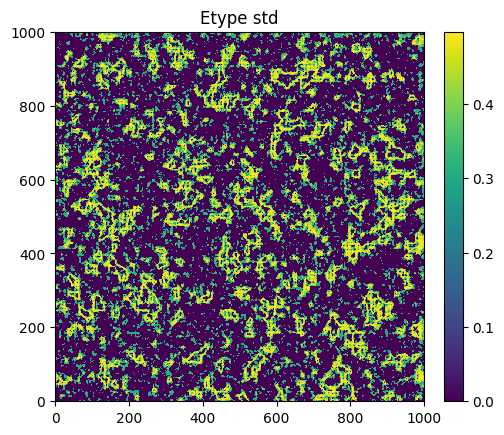

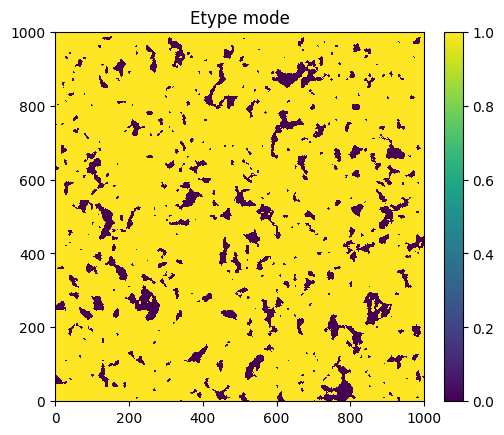

In [14]:
O.plot_etype()

/home/pedro2/Documents/GitHub/multi-point-statistics/scripts/utils.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


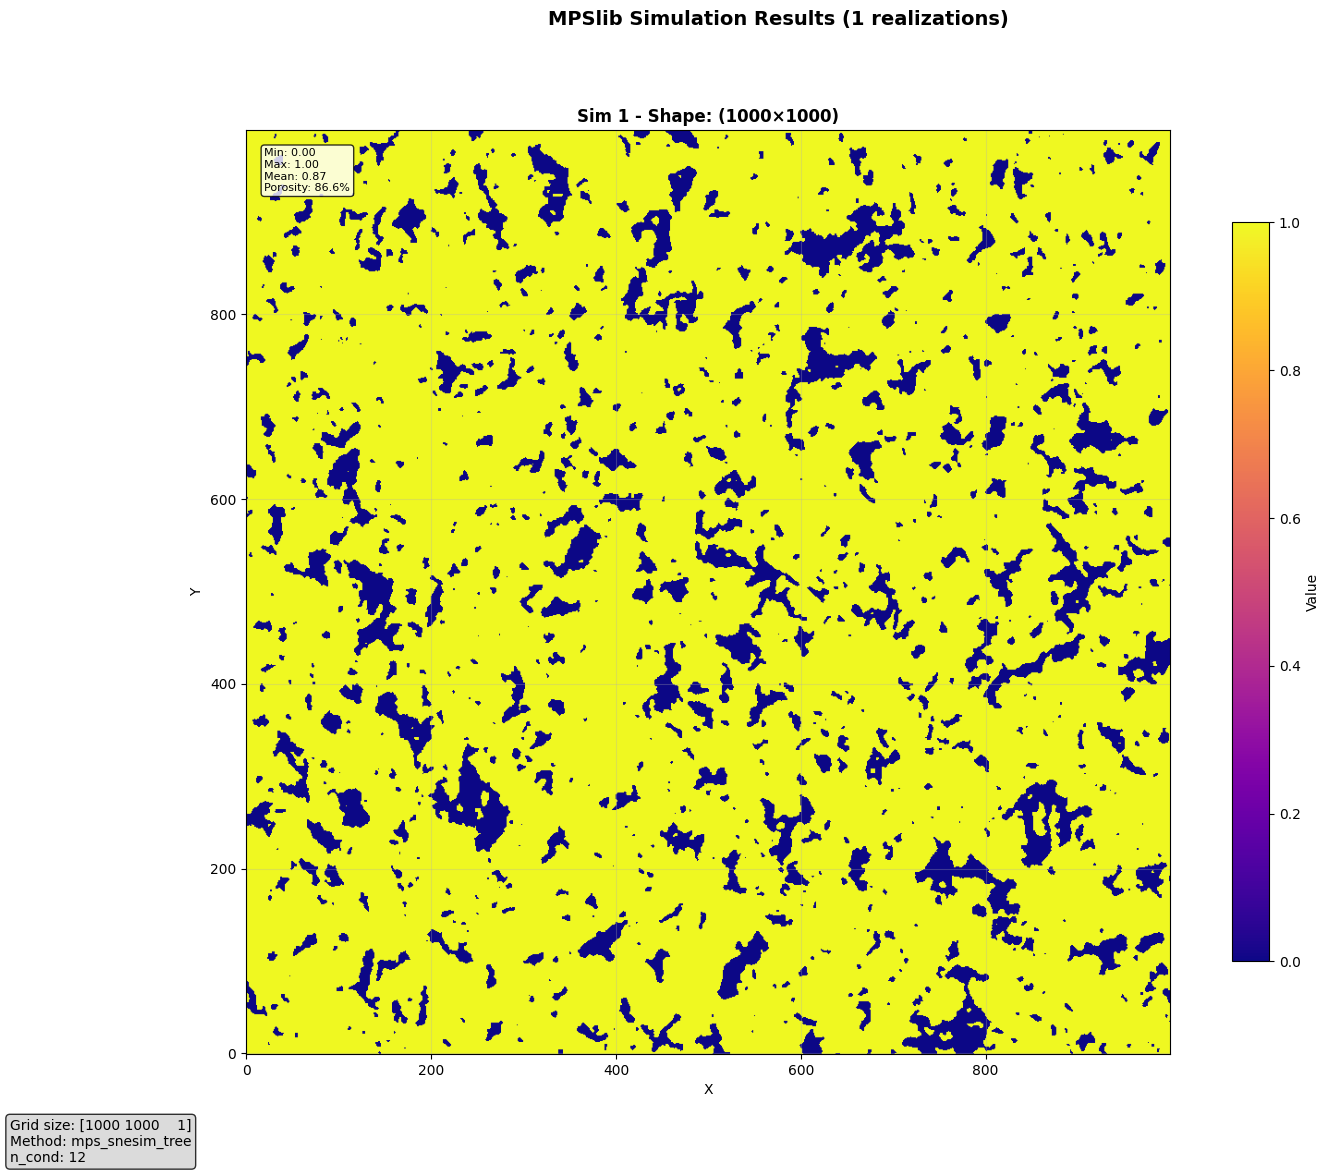

In [15]:
# Advanced usage
images = plot_realizations_enhanced(
    O, 
    n_realizations=1,           # Plot 6 realizations
    figsize=(16, 12),          # Larger figure
    cmap='plasma',             # Different colormap
    title_prefix="Sim",        # Custom title prefix
    # save_path="results.png",   # Save the plot
    # dpi=300                    # High resolution
)

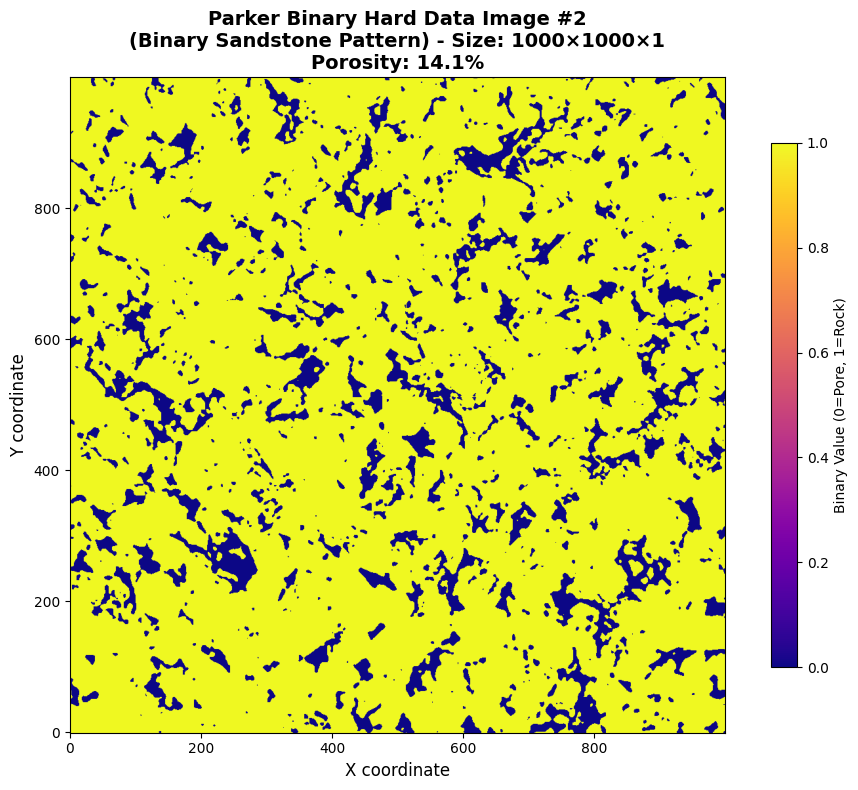

In [16]:
hard_data_array = np.load(hard_path + ".npy")  # Transformed version for visualization

# Calculate porosity (percentage of pore space, where 0=Pore, 1=Rock)
porosity = np.mean(hard_data_array[:,:,0] == 0) * 100

# Create a larger, better formatted plot
plt.figure(figsize=(10, 8))
plt.imshow(hard_data_array[:,:,0].T, cmap='plasma', origin='lower')
plt.title(f'Parker Binary Hard Data Image #{idx}\n(Binary Sandstone Pattern) - Size: {hard_data_array.shape[0]}×{hard_data_array.shape[1]}×{hard_data_array.shape[2]}\nPorosity: {porosity:.1f}%', fontsize=14, fontweight='bold')
plt.xlabel('X coordinate', fontsize=12)
plt.ylabel('Y coordinate', fontsize=12)
plt.colorbar(label='Binary Value (0=Pore, 1=Rock)', shrink=0.8)
plt.tight_layout()
plt.show()


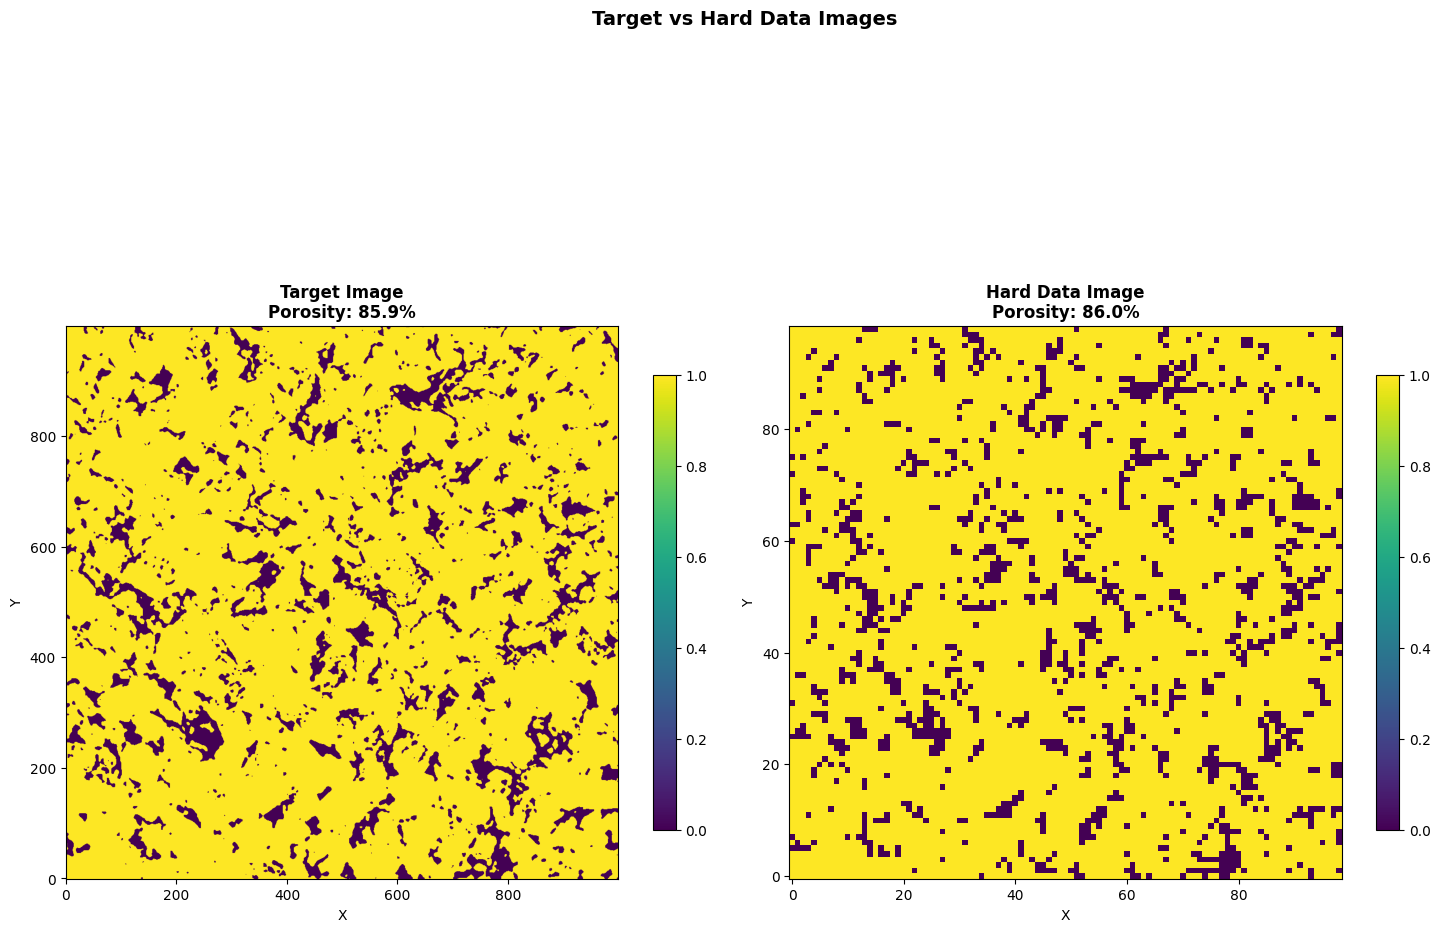

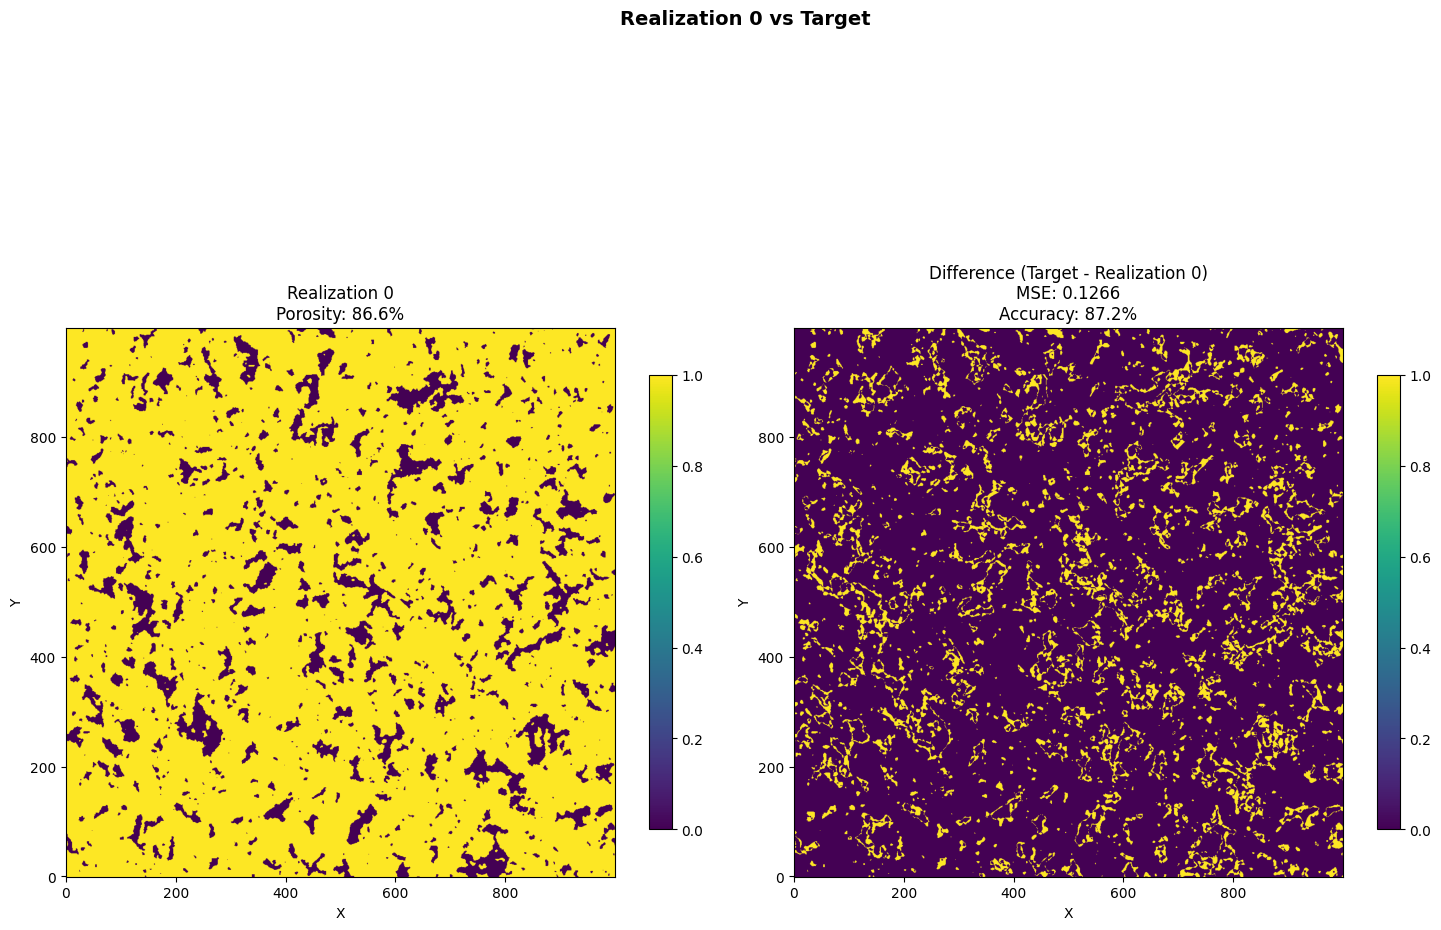

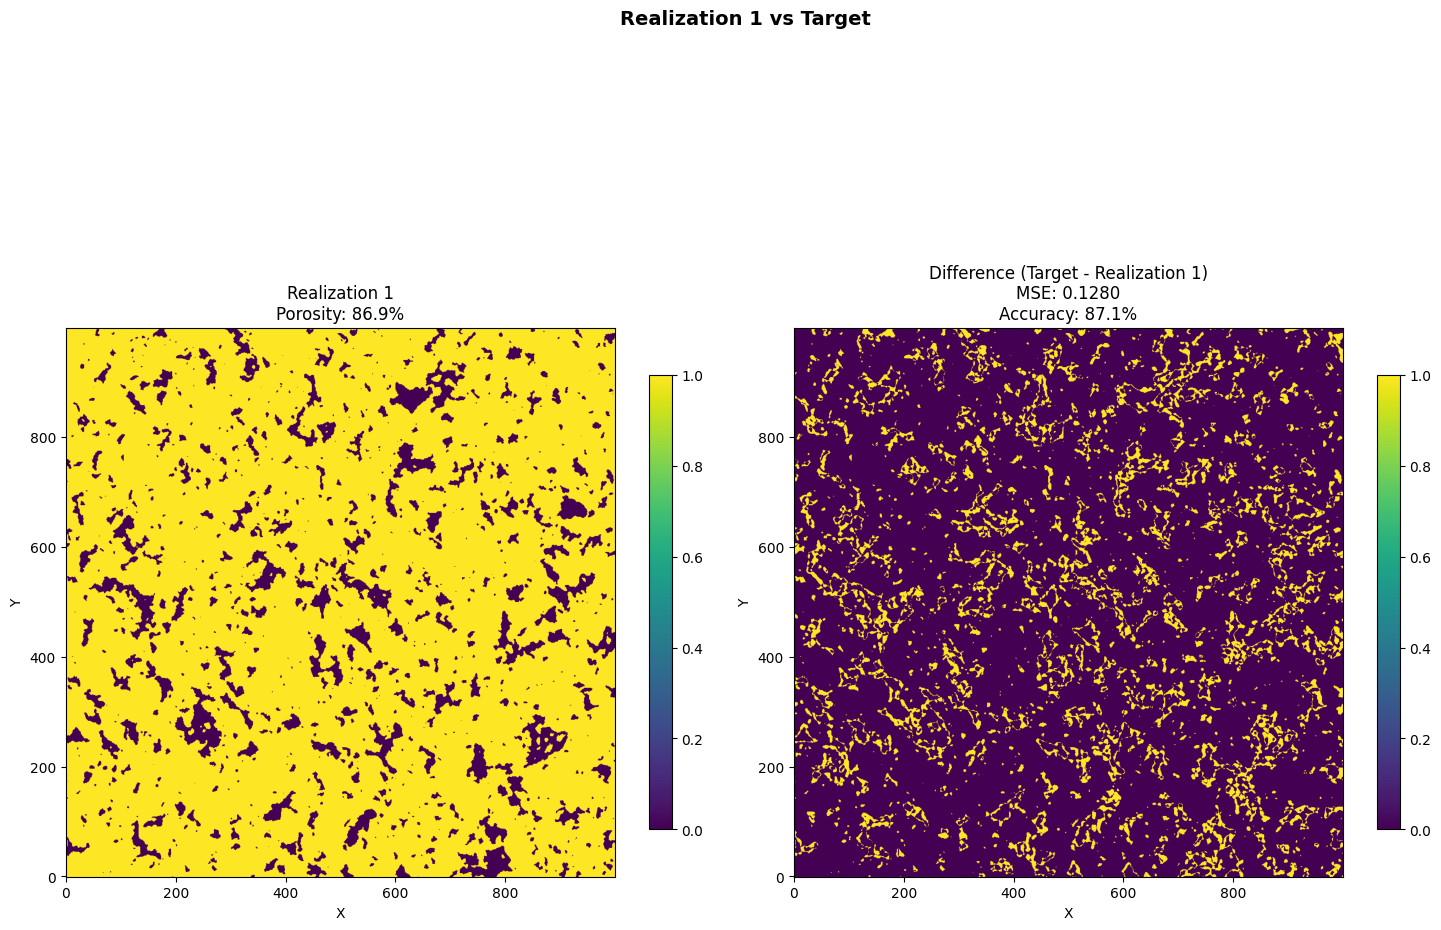

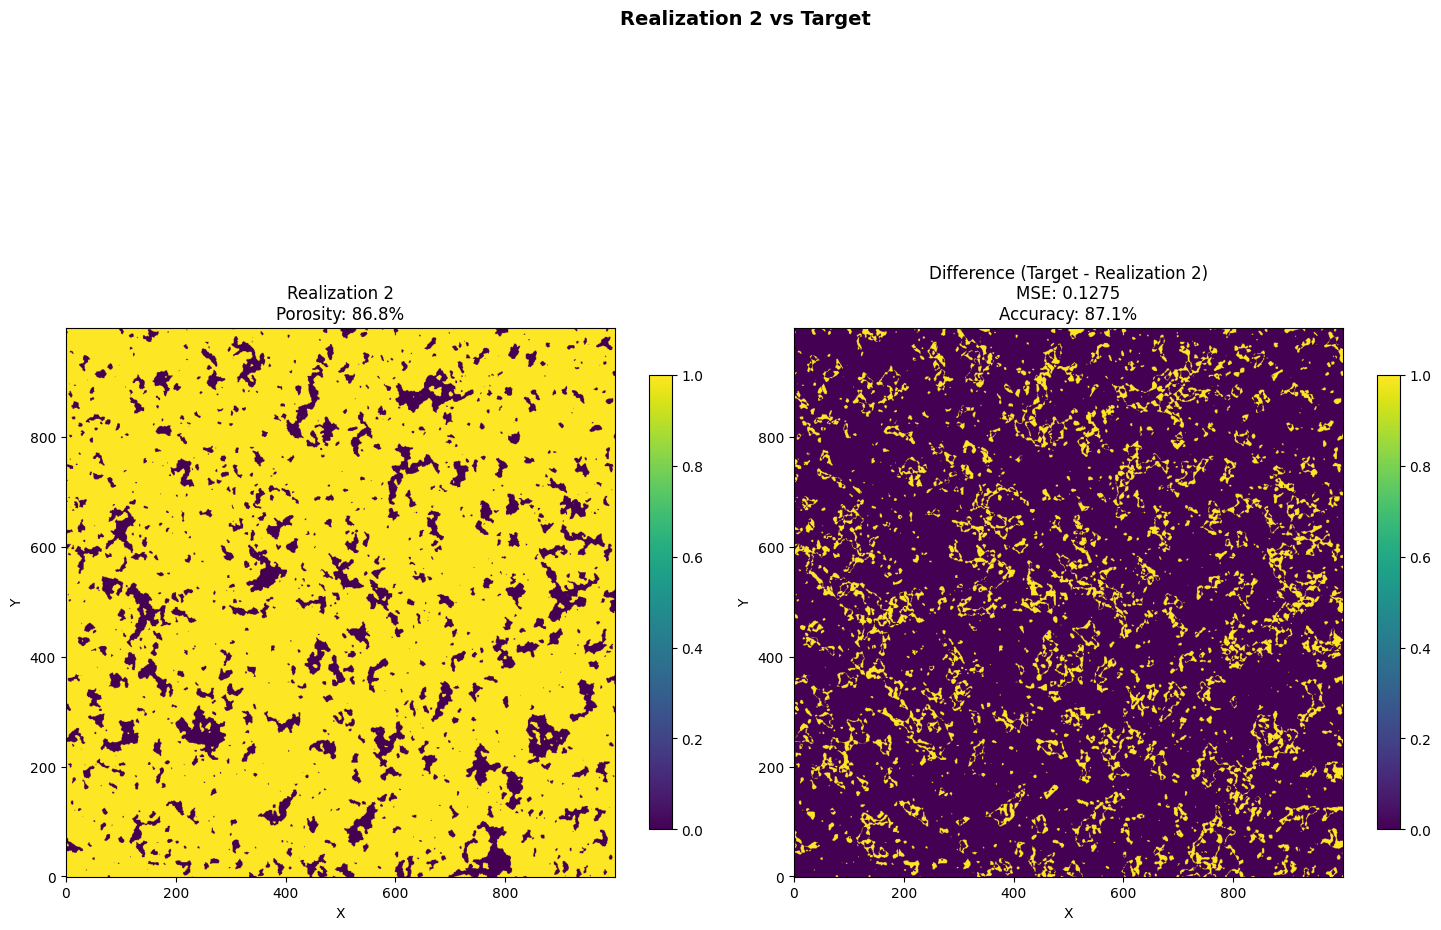

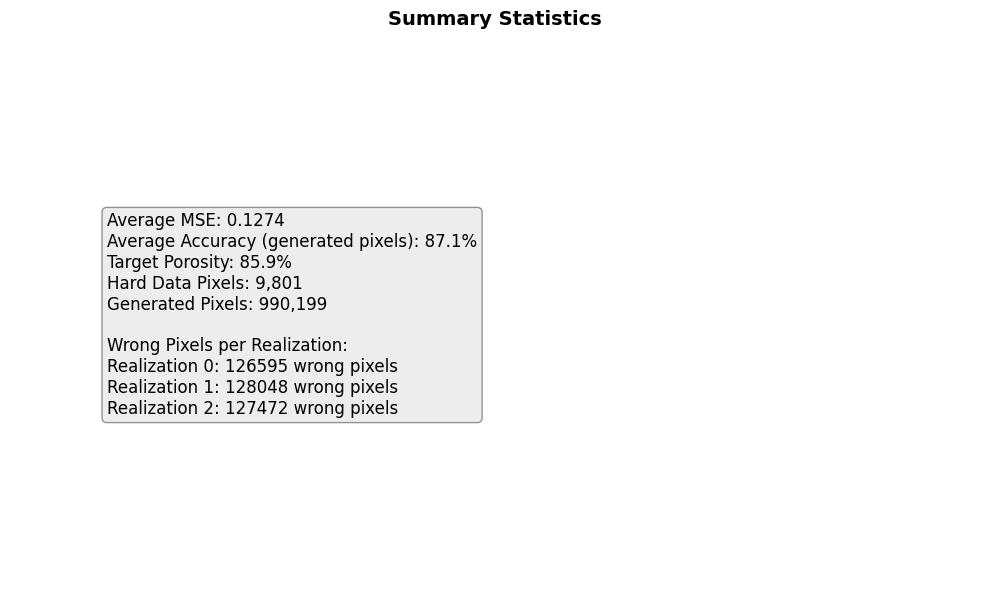

In [111]:
data = plot_mse_comparison(
    O,
    target_image=hard_data_array,
    hard_data_image=hard_data_transformed_array,
    n_realizations=3,
    figsize=(15, 12),
)

sink_horn